# Importing Libraries

In [1]:
import os, sys
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle
import matplotlib.pyplot as plt
import numpy as np
import re
import string
from numpy import array
from pickle import dump
from unicodedata import normalize
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from numpy.random import shuffle
from pickle import load


# Importing Data and Preprocessing

In [2]:
text=open('fra.txt','r',encoding='utf-8').read()
text=text.lower()

In [5]:
# Capping the dataset to include only the first 30,000 sentences
NUM_OF_SENTENCES=30000
i = 0
input_data=[]
output_data=[]
while i < NUM_OF_SENTENCES:
    word=text.rstrip().split('\n')[i]
    input_data.append(word.rstrip().split('\t')[0])
    output_data.append(word.rstrip().split('\t')[1])
    i += 1
 

In [6]:
# removing punctuations
source_sentences=[]
target_sentences=[]
for input in input_data:
    source_sentences.append(input.translate(str.maketrans('','',string.punctuation)))
for output in output_data:
    target_sentences.append(output.translate(str.maketrans('','',string.punctuation)))

In [8]:
pairs=[(source_sentences[i],target_sentences[i]) for i in range(0, NUM_OF_SENTENCES)]

In [9]:
pairs

[('go', 'va '),
 ('go', 'marche'),
 ('go', 'en route '),
 ('go', 'bouge '),
 ('hi', 'salut '),
 ('hi', 'salut'),
 ('run', 'cours\u202f'),
 ('run', 'courez\u202f'),
 ('run', 'prenez vos jambes à vos cous '),
 ('run', 'file '),
 ('run', 'filez '),
 ('run', 'cours '),
 ('run', 'fuyez '),
 ('run', 'fuyons '),
 ('run', 'cours\u202f'),
 ('run', 'courez\u202f'),
 ('run', 'prenez vos jambes à vos cous '),
 ('run', 'file '),
 ('run', 'filez '),
 ('run', 'cours '),
 ('run', 'fuyez '),
 ('run', 'fuyons '),
 ('who', 'qui '),
 ('wow', 'ça alors\u202f'),
 ('wow', 'waouh\xa0'),
 ('wow', 'wah\xa0'),
 ('duck', 'à terre\xa0'),
 ('duck', 'baissetoi\xa0'),
 ('duck', 'baissezvous\xa0'),
 ('fire', 'au feu '),
 ('help', 'à laide\u202f'),
 ('hide', 'cachetoi'),
 ('hide', 'cachezvous'),
 ('jump', 'saute'),
 ('jump', 'saute'),
 ('stop', 'ça suffit\u202f'),
 ('stop', 'stop\u202f'),
 ('stop', 'arrêtetoi '),
 ('wait', 'attends '),
 ('wait', 'attendez '),
 ('wait', 'attendez'),
 ('wait', 'attends '),
 ('wait', 'att

In [10]:
def to_list(pairs):
    list_data = list()
    for pair in pairs:
        pair_data = list()
        for line in pair:
            line = line.split()
            pair_data.append(' '.join(line))
        list_data.append(pair_data)
    return array(list_data)

In [11]:
list_data=to_list(pairs)

In [13]:
#saving data to pickle file
dump(list_data,open('english_to_french.pkl','wb'))

# Splitting into train and test

In [16]:
loaded_data=load(open('english_to_french.pkl','rb'))

In [17]:
dataset=loaded_data[:NUM_OF_SENTENCES,:]
shuffle(dataset)
train,test=dataset[:27000],dataset[27000:]

## Neural Translation Model

In [23]:
# tokenization and creating vocabulary

In [24]:
# tokenize english sentence
tokenizer_eng=Tokenizer()
tokenizer_eng.fit_on_texts(dataset[:,0])
eng_vocab_size=len(tokenizer_eng.word_index)+1
eng_max_length=max(len(line.split())for line in dataset[:,0])
print("ENG vocab size",eng_vocab_size)
print("ENG max length",eng_max_length)
# tokenize french sentences
tokenizer_fr=Tokenizer()
tokenizer_fr.fit_on_texts(dataset[:,1])
french_vocab_size=len(tokenizer_fr.word_index)+1
french_max_length=max(len(line.split())for line in dataset[:,1])
print("French vocab size",french_vocab_size)
print("French max length",french_max_length)

ENG vocab size 4411
ENG max length 6
French vocab size 9142
French max length 12


# Encoding and Padding

In [26]:
# encoding sequences for train and test 
def tokenize_data(data):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(data)
    return tokenizer
X_train=tokenize_data(dataset[:,1]).text_to_sequences(eng_max_length,train[:,0])
X_train=pad_sequences(X_train,maxlen=eng_max_length,padding='post')

X_test=tokenize_data(dataset[:,1]).text_to_sequences(eng_max_length,train[:,0])
X_train=pad_sequences(X_test,maxlen=eng_max_length,padding='post')

Y_train=tokenize_data(dataset[:,1]).text_to_sequences(french_max_length,train[:,1])
Y_train=pad_sequences(Y_train,maxlen=french_max_length,padding='post')

Y_test=tokenize_data(dataset[:,1]).text_to_sequences(french_max_length,train[:,1])
Y_test=pad_sequences(Y_test,maxlen=french_max_length,padding='post')

In [27]:
# one hot encode output sequences
Y_train_output_list=list()
for output_seq in Y_train:
    one_hot_encode=to_categorical(output_seq,num_classes=french_vocab_size)
    Y_train_output_list.append(one_hot_encode)
op=array(Y_train_output_list)
Y_train=op.reshape(Y_train.shape[0],Y_train.shape[1],french_vocab_size)


Y_test_output_list=list()
for output_seq in Y_test:
    one_hot_encode=to_categorical(output_seq,num_classes=french_vocab_size)
    Y_test_output_list.append(one_hot_encode)
op=array(Y_test_output_list)
Y_test=op.reshape(Y_test.shape[0],Y_test.shape[1],french_vocab_size)


# Defining model

In [31]:
def define_model(source_vocab, target_vocab, source_timesteps, 
                 target_timesteps, n_units):
    model=Sequential()
    model.add(Embedding(source_vocab,n_units,input_length=source_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(target_timesteps))
    model.add(LSTM(n_units,return_sequences=True))
    model.add(TimeDistributed(Dense(target_vocab, activation='softmax')))
    return model

In [32]:
model = define_model(eng_vocab_size, french_vocab_size, 
                     eng_max_length, french_max_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 256)            1129216   
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVecto  (None, 12, 256)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 12, 256)           525312    
                                                                 
 time_distributed (TimeDist  (None, 12, 9142)          2349494   
 ributed)                                                        
                                                                 
Total params: 4529334 (17.28 MB)
Trainable params: 452

In [33]:
# fitting the model
epochs=30
batch_size=64
filename='english_to_french.h5'
checkpoint=ModelCheckpoint(filename,monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
history=model.fit(X_train,Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                 validation_data=(X_test,Y_test),
                 callbacks=[checkpoint],
                 verbose=1)

Epoch 1/30

422/422 [==============================] - ETA: 0s - loss: 2.4495
Epoch 1: val_loss improved from inf to 2.00789, saving model to english_to_french.h5


C:\Users\manis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


422/422 [==============================] - 85s 185ms/step - loss: 2.4495 - val_loss: 2.0079
Epoch 2/30
422/422 [==============================] - ETA: 0s - loss: 1.9520
Epoch 2: val_loss improved from 2.00789 to 1.91743, saving model to english_to_french.h5
422/422 [==============================] - 72s 171ms/step - loss: 1.9520 - val_loss: 1.9174
Epoch 3/30
422/422 [==============================] - ETA: 0s - loss: 1.8378
Epoch 3: val_loss improved from 1.91743 to 1.84207, saving model to english_to_french.h5
422/422 [==============================] - 72s 172ms/step - loss: 1.8378 - val_loss: 1.8421
Epoch 4/30
422/422 [==============================] - ETA: 0s - loss: 1.7349
Epoch 4: val_loss improved from 1.84207 to 1.75267, saving model to english_to_french.h5
422/422 [==============================] - 75s 177ms/step - loss: 1.7349 - val_loss: 1.7527
Epoch 5/30
422/422 [==============================] - ETA: 0s - loss: 1.6130
Epoch 5: val_loss improved from 1.75267 to 1.64418, savin

In [34]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


# Plotting val_loss and loss

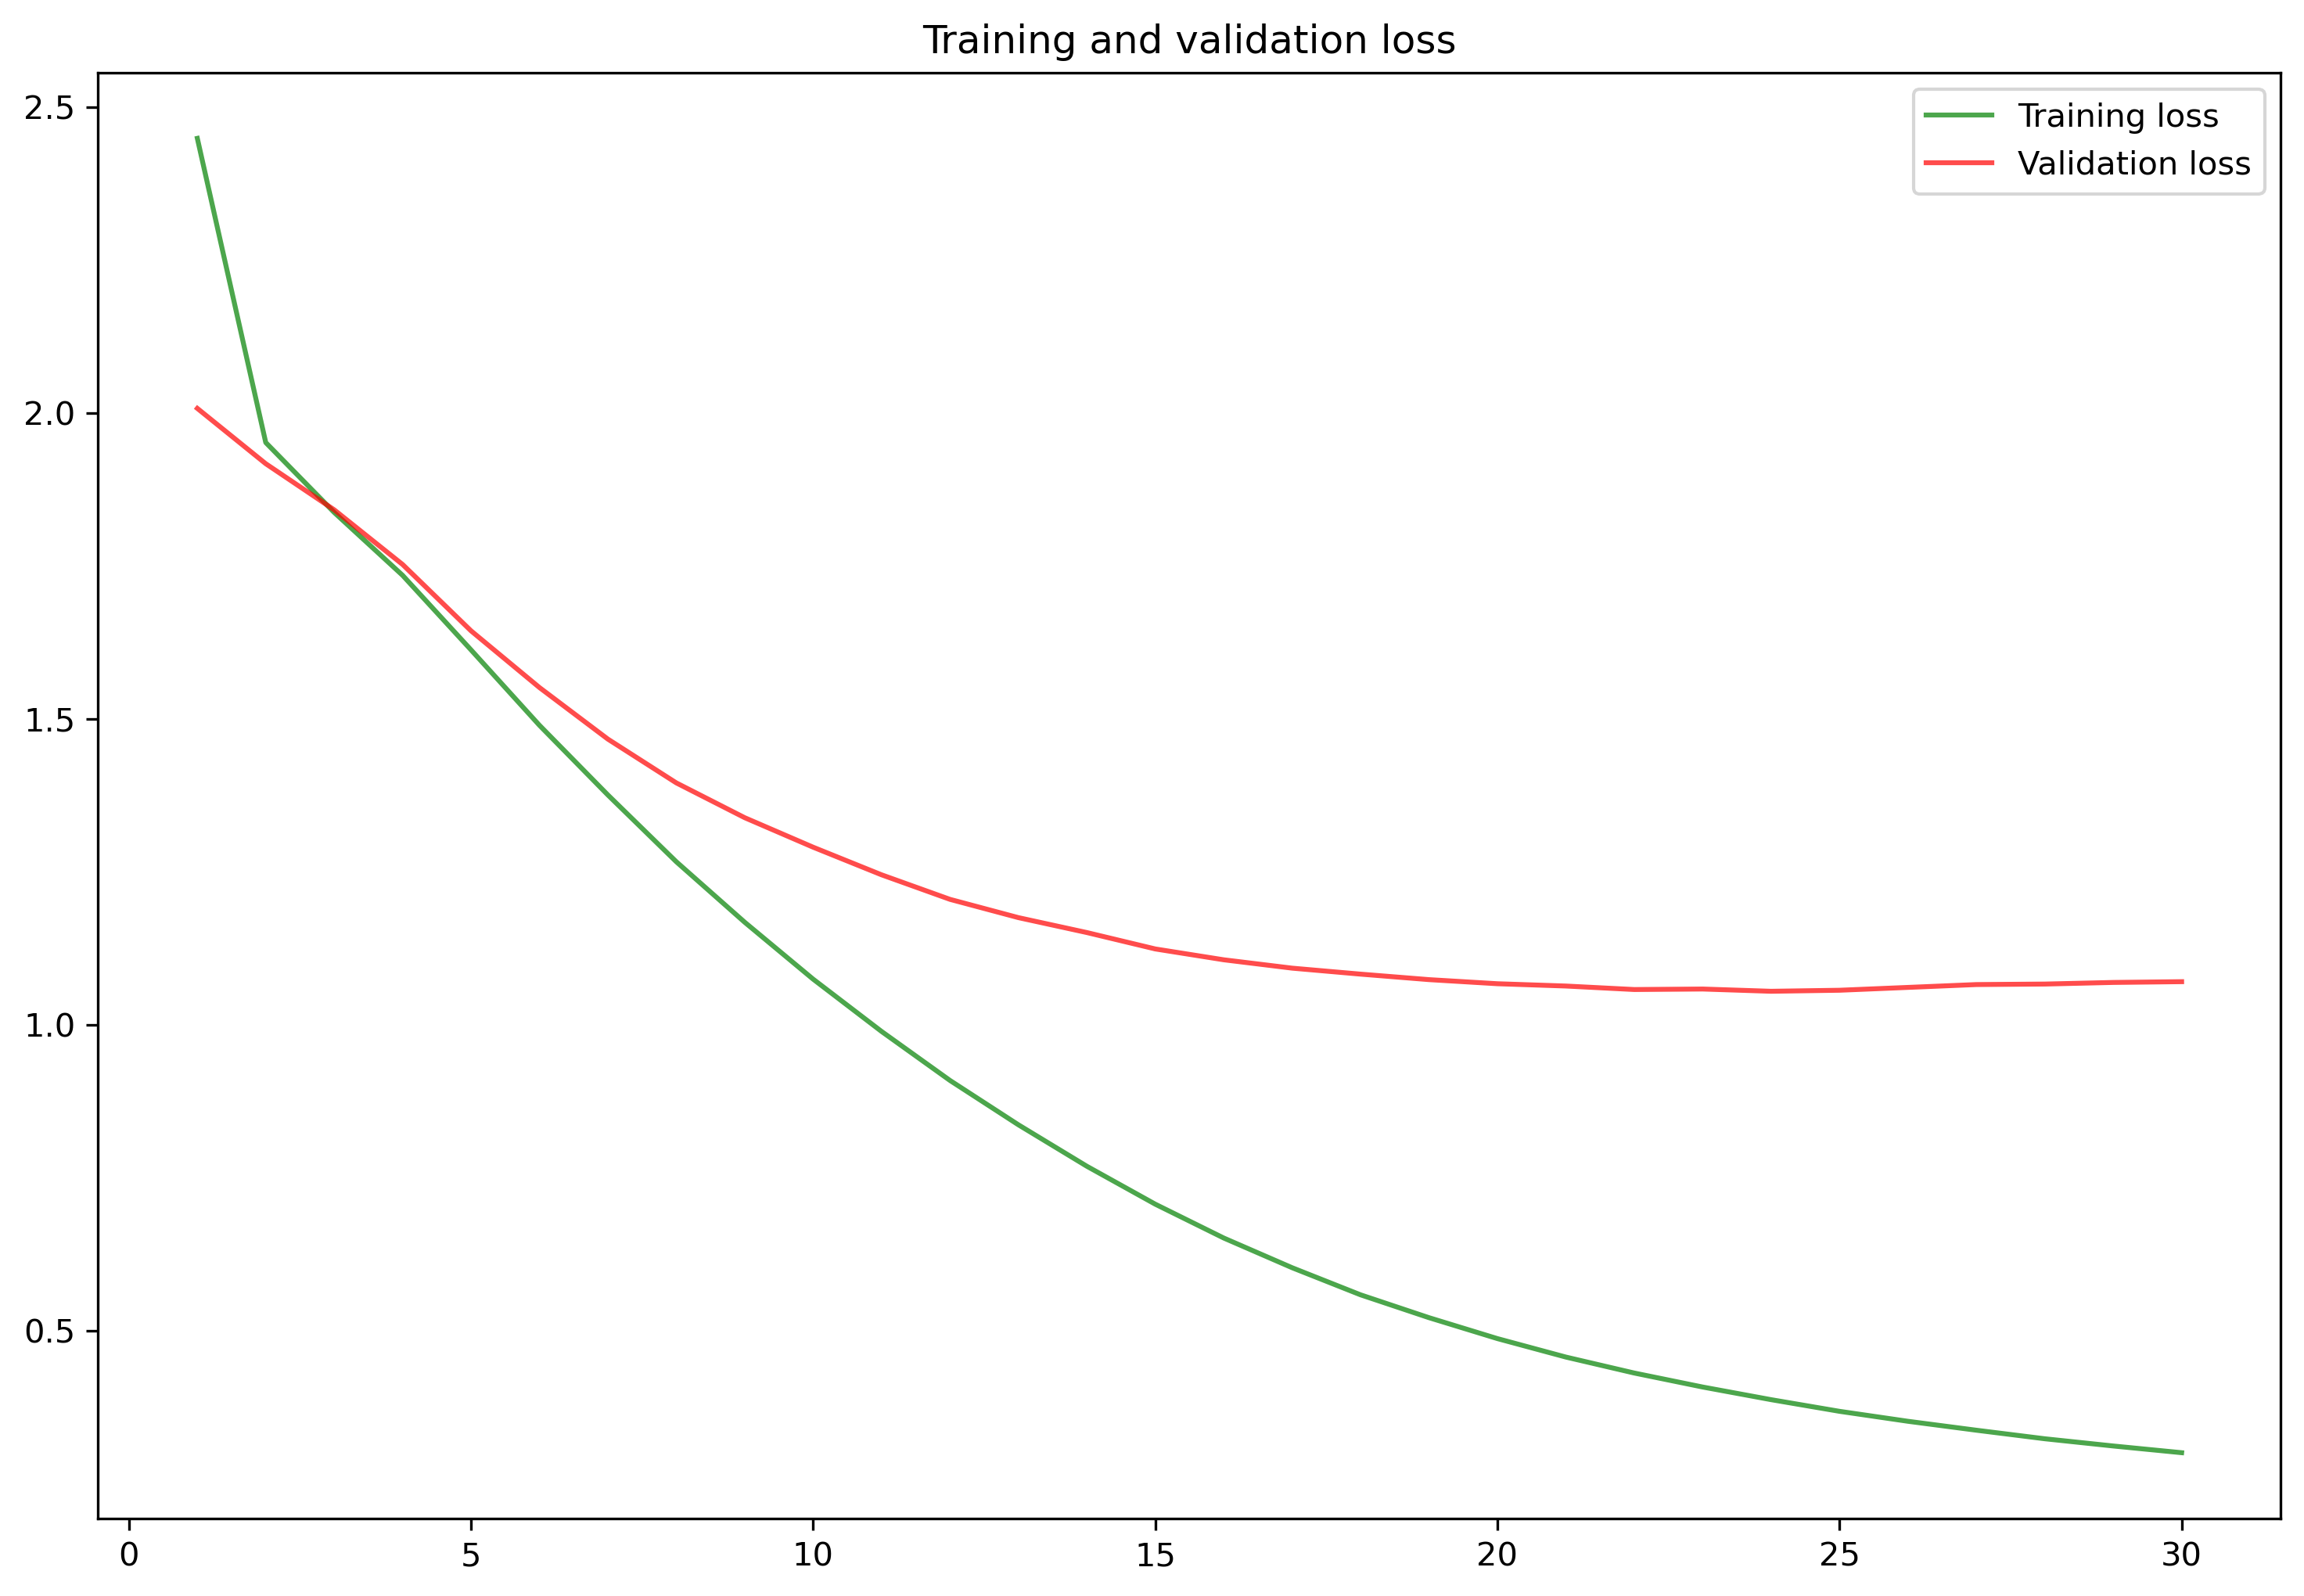

In [36]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)
plt.figure(figsize=(12,8),dpi=300)
plt.plot(epochs, loss, '-g', label='Training loss', alpha=0.7)
plt.plot(epochs, val_loss, '-r', label='Validation loss', alpha=0.7)
plt.title('Training and validation loss')
plt.legend()
plt.savefig('losses.png')


In [112]:
# map id to word
def map_id(id, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == id:
            return word
    return None

# generate target sequence from source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    values = [argmax(preds) for preds in prediction]
    target = list()
    for i in values:
        word = map_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

# evaluate the model
def evaluate_model(model, tokenizer, sources, dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        source = source.reshape(1, source.shape[0])
        translation = predict_sequence(model, tokenizer, source)
        raw_source, raw_target = dataset[i]
        if i < 20:
            print('SOURCE=%s, TARGET=%s, PREDICTED=%s' % (raw_source, raw_target, translation))
            
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    return predicted
            
# test on test data
print('test')
predicted=[]
predicted=evaluate_model(model, tokenizer_fr, X_test, test)

test
SOURCE=burn it, TARGET=brûlele, PREDICTED=brûlezla
SOURCE=are we alone, TARGET=sommesnous seules, PREDICTED=sommesnous seuls
SOURCE=no problem, TARGET=sans problème, PREDICTED=pas de problème
SOURCE=love is beautiful, TARGET=cest beau lamour, PREDICTED=aujourdhui est est
SOURCE=i will choose one, TARGET=jen choisirai une, PREDICTED=je choisirai juste choisir
SOURCE=did i wake you up, TARGET=vous aije réveillé, PREDICTED=vous aije réveillé
SOURCE=i didnt cry, TARGET=je nai pas pleuré, PREDICTED=je nai pas hurlé
SOURCE=its a full moon, TARGET=cest une période de pleine lune, PREDICTED=cest est longue
SOURCE=do you bowl, TARGET=jouezvous au bowling, PREDICTED=jouestu au bowling
SOURCE=i oppose it, TARGET=jy suis opposé, PREDICTED=je suis oppose
SOURCE=its our job, TARGET=cest notre boulot, PREDICTED=cest notre boulot
SOURCE=please help us, TARGET=aideznous sil vous plaît, PREDICTED=veuillez je vous prie
SOURCE=i hate you both, TARGET=je vous déteste toutes les deux, PREDICTED=je vous

## Evaluating the model using BLEU Scoring

In [77]:
from datasets import load_metric 
  
bleu = load_metric("bleu") 

C:\Users\manis\AppData\Local\Temp\ipykernel_23468\2846646940.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu = load_metric("bleu")


In [115]:
predictions = [['je', 'ne', 'suis', 'pas', 'contente']]
references = [ 
    [['je', 'ne', 'suis', 'pas', 'heureux']] ]
print(bleu.compute(predictions=predictions, references=references)) 

{'bleu': 0.668740304976422, 'precisions': [0.8, 0.75, 0.6666666666666666, 0.5], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 5, 'reference_length': 5}
